In [23]:
# Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [24]:
# Define the assets and time range
assets = ['TSLA', 'BND', 'SPY']
start_date = '2015-01-01'
end_date = '2024-10-31'

In [25]:
# Load Data for TSLA, BND, and SPY
data = yf.download(assets, start=start_date, end=end_date)['Close']
data = data.dropna()

[*********************100%***********************]  3 of 3 completed


In [26]:
# Calculate Daily Returns
returns = data.pct_change().dropna()


forecasted_returns = {
    'TSLA': 0.15,  
    'BND': 0.03,   
    'SPY': 0.10    
}

In [27]:
# Convert forecasted annual returns to daily returns
forecasted_daily_returns = {asset: (1 + forecasted_returns[asset])**(1/252) - 1 for asset in assets}

# Calculate Covariance Matrix of Daily Returns
cov_matrix = returns.cov()


In [28]:
# Define Functions for Portfolio Optimization

# Portfolio Performance: Calculates return and volatility for given weights
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    return returns, volatility

In [29]:
# Negative Sharpe Ratio: Used to maximize Sharpe Ratio by minimizing its negative
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.02):
    p_return, p_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_return - risk_free_rate) / p_volatility

In [30]:
# Constraints: Sum of weights is 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds for each weight (0 to 100%)
bounds = tuple((0, 1) for asset in range(len(assets)))

# Initial Guess (Equal Weights)
initial_weights = [1/len(assets) for asset in range(len(assets))]

# Perform Optimization
optimal = minimize(neg_sharpe_ratio, initial_weights, args=(list(forecasted_daily_returns.values()), cov_matrix), 
                   method='SLSQP', bounds=bounds, constraints=constraints)


In [31]:
# Optimal Weights
optimal_weights = optimal.x
print("Optimal Portfolio Weights:")
for asset, weight in zip(assets, optimal_weights):
    print(f"{asset}: {weight:.2%}")

# Calculate Portfolio Metrics
p_return, p_volatility = portfolio_performance(optimal_weights, list(forecasted_daily_returns.values()), cov_matrix)
sharpe_ratio = (p_return - 0.02) / p_volatility  #  a risk-free rate of 2%

print(f"\nOptimized Portfolio Performance:")
print(f"Expected Annual Return: {p_return:.2%}")
print(f"Annual Volatility (Risk): {p_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Optimal Portfolio Weights:
TSLA: 99.97%
BND: 0.00%
SPY: 0.03%

Optimized Portfolio Performance:
Expected Annual Return: 13.98%
Annual Volatility (Risk): 5.49%
Sharpe Ratio: 2.18


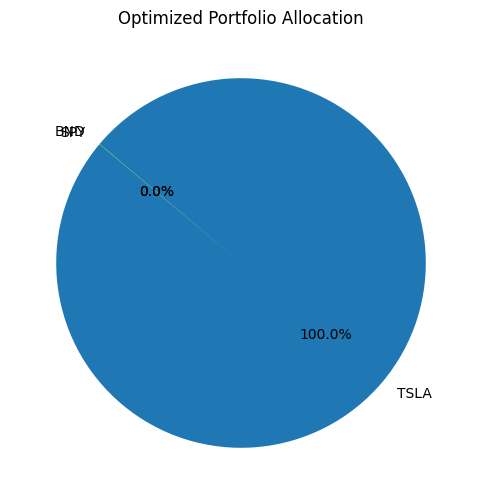

In [32]:
# Plot Portfolio Allocation
plt.figure(figsize=(10, 6))
plt.pie(optimal_weights, labels=assets, autopct='%1.1f%%', startangle=140)
plt.title('Optimized Portfolio Allocation')
plt.show()


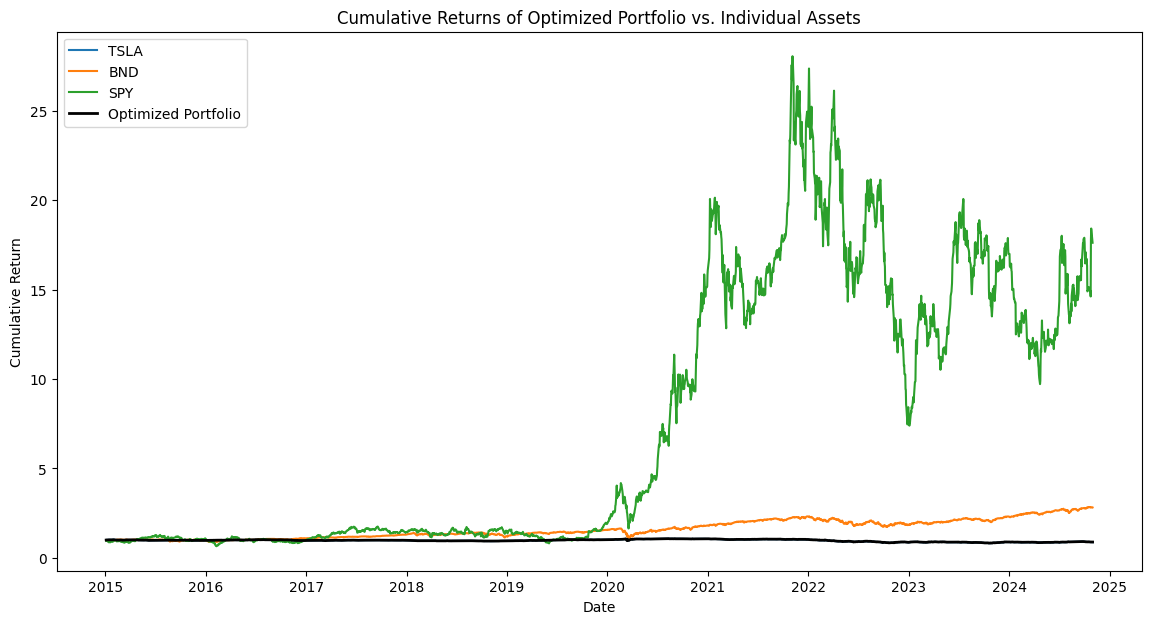

In [33]:
# Analysis of Portfolio Performance over Time (Historical Backtest)
cumulative_returns = (returns + 1).cumprod()
portfolio_returns = cumulative_returns.dot(optimal_weights)

plt.figure(figsize=(14, 7))
plt.plot(cumulative_returns, label=assets)
plt.plot(portfolio_returns, label='Optimized Portfolio', color='black', linewidth=2)
plt.legend(loc='upper left')
plt.title("Cumulative Returns of Optimized Portfolio vs. Individual Assets")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.show()